In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt

import uf3
from uf3.data.io import DataCoordinator
from uf3.data.composition import ChemicalSystem
from uf3.representation.process import BasisProcessor2B
from uf3.regression.regularize import Regularizer
from uf3.regression.least_squares import WeightedLinearModel

from uf3.representation import distances
from uf3.util import plotting
from uf3.forcefield import lammps


pkg_directory = os.path.dirname(os.path.dirname(uf3.__file__))
example_directory = os.path.join(pkg_directory, "examples", "Ne-Xe")
dataset_directory = os.path.join(pkg_directory, "examples", "Ne-Xe", "dataset")

# User Parameters

In [2]:
n_jobs = 8                              # Maximum number of parallel processes

element_list = ['Ne', 'Xe']
degree = 2                              # two-body interactions

r_min_map = {('Ne', 'Ne'): 1.5,
             ('Ne', 'Xe'): 1.5,
             ('Xe', 'Xe'): 1.5,}        # minimum distance cutoff (angstroms)
r_max_map = {('Ne', 'Ne'): 6.0,
             ('Ne', 'Xe'): 8.0,
             ('Xe', 'Xe'): 8.0,}        # maximum distance cutoff (angstroms)
resolution_map = {('Ne', 'Ne'): 25,
                  ('Ne', 'Xe'): 25,
                  ('Xe', 'Xe'): 25}     # number of knot intervals

lammps_aliases = {1: 'Ne',
                  2: 'Xe'}              # aliases for LAMMPS atom types

lambda1 = 1e-5                          # L2 (Ridge) regularization strength
lambda2 = 1e-4                          # Curvature regularization strength

# Initialize data coordinator and chemical system

In [3]:

data_coordinator = DataCoordinator()

chemical_system = ChemicalSystem(element_list=element_list,
                                 degree=degree,
                                 r_min_map=r_min_map,
                                 r_max_map=r_max_map,
                                 resolution_map=resolution_map)



# Load data from LAMMPS run directory

In [4]:
data_coordinator.dataframe_from_lammps_run(dataset_directory,
                                           lammps_aliases,
                                           prefix='lmp',
                                           log_fname="log.lammps",
                                           dump_fname="dump.lammpstrj")
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))


Number of energies: 401
Number of forces: 76992


In [5]:
df_data.head()


,Step,Temp,Press,TotEng,energy,geometry,size,fx,fy,fz
lmp_0,0,0.100000,0.300731,-4.425584,-4.426398,"(Atom('Ne', [15.123913088599998, 15.1239130885...",64.0,"[0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0...","[0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0...","[-0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."
lmp_1,1000,5.624945,-73.317322,-4.412308,-4.458114,"(Atom('Ne', [15.165314343599999, 15.1792692817...",64.0,"[0.00020442650000000002, 0.0016639457, 0.00192...","[0.0056729229, 0.0009264524000000001, 0.002516...","[-0.0015951115, -0.0019227623, -0.0035339883, ..."
lmp_2,2000,10.808590,-428.025400,-4.639121,-4.727139,"(Atom('Ne', [0.9063913729, 1.3488837163999998,...",64.0,"[0.0015836835999999998, -0.0023350728, 0.00265...","[-3.38791e-05, 0.002999284, -0.0060387845, 0.0...","[-0.0036139710999999997, -0.0023498482, 0.0036..."
lmp_3,3000,14.861731,-1202.434200,-4.878347,-4.999372,"(Atom('Ne', [1.3474466084, 1.2753605426, 14.56...",64.0,"[-0.004552505300000001, 0.0010418925, -0.00689...","[0.004840957700000001, -0.0004996062000000001,...","[0.0098480452, 0.0022208212, 5.97758e-05, -0.0..."
lmp_4,4000,20.299581,-1269.661700,-4.843280,-5.008587,"(Atom('Ne', [1.7462606202000002, 1.4321776581,...",64.0,"[-0.0036245833000000003, 0.0027762812, 0.00332...","[0.0002289233, 0.0005190723000000001, 0.009913...","[0.0008959326, 0.000723354, 0.0071951805, -0.0..."


# Visualize partial radial distribution functions
### This can be a sanity check for specified interaction-specific cutoffs.

In [6]:
atoms_key = data_coordinator.atoms_key
histograms = distances.summarize_distances(df_data[atoms_key],
                                           chemical_system)

('Ne', 'Ne') Lower bound: 2.160 angstroms
('Ne', 'Ne') Peaks (min width 0.5 angstroms): [2.82 5.46]
('Ne', 'Xe') Lower bound: 2.640 angstroms
('Ne', 'Xe') Peaks (min width 0.5 angstroms): [ 3.66  7.98 10.74]
('Xe', 'Xe') Lower bound: 3.360 angstroms
('Xe', 'Xe') Peaks (min width 0.5 angstroms): [ 4.26  7.14 11.1 ]


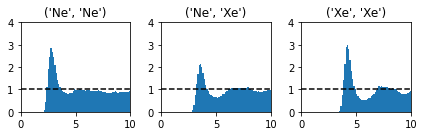

In [7]:
bar_width = histograms[1][1] - histograms[1][0]
pairs = chemical_system.interactions_map[2]
fig, ax = plt.subplots(1, len(pairs), figsize=(len(pairs)*2, 2))
for i, pair in enumerate(pairs):
    ax[i].bar(histograms[1][:-1],
              histograms[0][pair],
              width=bar_width)
    ax[i].set_title(pair)
    ax[i].plot([0, 10], [1, 1], linestyle='--', color='k')
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 4)
fig.tight_layout()

# Initialize representation, regularizer, and model


In [8]:
representation = BasisProcessor2B(chemical_system)

regularizer_sizes = representation.get_regularizer_sizes()
regularizer = Regularizer(regularizer_sizes=regularizer_sizes,
                          ridge=lambda1,
                          curvature=lambda2,
                          onebody=lambda1 * 1000)

fixed = regularizer.get_fixed(value=0,
                              onebody=True,
                              upper_bounds=True,
                              lower_bounds=False)
model = WeightedLinearModel(regularizer=regularizer,
                            fixed=fixed)

client = ProcessPoolExecutor(max_workers=n_jobs)

# Compute energy and force features using B-spline basis

In [ ]:
n_batches = 5  # added granularity for more progress bar updates (optional).
df_features = representation.evaluate_parallel(df_data,
                                               data_coordinator,
                                               client,
                                               n_jobs=n_jobs * n_batches)

 22%|██▎       | 9/40 [00:06<00:27,  1.11it/s]

In [ ]:
df_features.head()

# Fit with 25% of the data
### Weighing energies and forces equally with kappa = 0.5

In [ ]:
frac_train = 0.25
kappa = 0.5  # energy-force weighting parameter between 0 and 1.

n_samples_per_config = 1 + 64 * 3
n_train = n_samples_per_config * int(frac_train * len(df_data))
df_train = df_features.iloc[:n_train]
x, y, w = representation.get_training_tuples(df_train,
                                             kappa,
                                             data_coordinator)

In [ ]:
model.fit(x, y, weights=w)

# Evaluate Energy and Forces with model

In [ ]:
# Evaluate energy
df_test = df_features.iloc[n_train:]
x_test, y_test, w_cond = representation.get_training_tuples(df_test,
                                                            0,
                                                            data_coordinator)
# slice entries corresponding to energies per atom
x_e = x_test[w_cond == 0] / 64
y_e = y_test[w_cond == 0] / 64
# slice entries corresponding to forces
x_f = x_test[w_cond > 0]
y_f = y_test[w_cond > 0]
# predict with solution
p_e = model.predict(x_e)  # energy per atom
p_f = model.predict(x_f)

# Compute root-mean-square error

In [ ]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print("Energy RMSE:", rmse_e, "eV/atom")
print("Forces RMSE:", rmse_f, "eV/angstrom")

# Arrange solution into pair-interaction potentials

In [ ]:
solutions_list = np.array_split(model.coefficients,
                                np.cumsum(regularizer_sizes)[:-1])
solutions = {element: value for element, value
             in zip(chemical_system.element_list, solutions_list[-1])}
for i, pair in enumerate(chemical_system.interactions_map[2]):
    solutions[pair] = solutions_list[i]

In [ ]:
for key, value in solutions.items():
    if isinstance(value, (float, np.floating)):
        print("{0}: {1:.6f}".format(key, value))
    else:
        print("{}: vector".format(key), value.shape)

# Compute true Lennard-Jones potentials for reference

In [ ]:
plot_reference = False  # set to True to compute and plot.


def get_lennard_jones(r_range, epsilon, sigma):
    return 4 * epsilon * ((sigma/r_range)**12 - (sigma/r_range)**6)

if plot_reference:
    r_plot = np.linspace(2, 12, 1000)
    yaa = get_lennard_jones(r_plot, 0.003705453303, 2.73) / 2
    yab = get_lennard_jones(r_plot, 0.006323399148, 3.472) / 2
    ybb = get_lennard_jones(r_plot, 0.02206037315, 3.92) / 2

# Plot results


In [ ]:
y_min = -0.015
y_max = 0.03
ENERGY_UNITS = "eV/atom"
FORCE_UNITS = "eV/$\mathrm{\AA}$"

fig = plt.figure(figsize=(7.48, 4), dpi=160, facecolor='white')
gs = fig.add_gridspec(ncols=3, nrows=2,
                      width_ratios=[1, 1, 1],
                      height_ratios=[0.5, 1])

for i, pair in enumerate(chemical_system.interactions_map[2]):
    ax = fig.add_subplot(gs[0, i])
    r_min = r_min_map[pair]
    r_max = r_max_map[pair]
    knot_sequence = representation.knots_map[pair]
    coefficients = solutions[pair]
    plotting.visualize_splines(coefficients,
                               knot_sequence,
                               ax=ax,
                               s_min=y_min,
                               s_max=y_max,
                               linewidth=1)
    ax.set_ylabel('B-Spline Value')
    ax.set_xlabel('$\mathrm{r_{ij}~~(\AA)}$')
    ax.set_title(pair)
ax2 = fig.add_subplot(gs[1, 0])
plotting.density_scatter(y_e, p_e, ax=ax2, units=ENERGY_UNITS, text_size=6, label_size=10)
ax2.set_xlabel('Reference ({})'.format(ENERGY_UNITS))
ax2.set_ylabel('Prediction ({})'.format(ENERGY_UNITS))

ax3 = fig.add_subplot(gs[1, 1])
plotting.density_scatter(y_f, p_f, ax=ax3, units=FORCE_UNITS,
                         text_size=6, label_size=10)
ax3.set_xlabel('Reference ({})'.format(FORCE_UNITS))
ax3.set_ylabel('Prediction ({})'.format(FORCE_UNITS))

ax2.set_title('Energy Predictions')
ax3.set_title('Force Predictions')
fig.subplots_adjust(left=0.1, right=0.99,
                    bottom=0.15, top=0.94,
                    wspace=0.6, hspace=0.6)
if plot_reference:
    fig.get_axes()[0].plot(r_plot, yaa, color='red', linewidth=2, linestyle=':')
    fig.get_axes()[1].plot(r_plot, yab, color='red', linewidth=2, linestyle=':')
    fig.get_axes()[2].plot(r_plot, ybb, color='red', linewidth=2, linestyle=':')
fig.show()

# Export tabulated potentials

In [ ]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
print(combined_text)
fname = os.path.join(example_directory, "table_test", "Ne_Xe.table")
with open(fname, "w") as f:
    f.write(combined_text)